### Import required libraries

In [36]:
import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

%matplotlib inline

### Increase the size of the screen

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [3]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

    #Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the normalized table

In [4]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instance_normalized', con = conn)
print("--- %s seconds ---" % (time.time() - start_time))

df.drop(['index'],axis=1, inplace=True)
df.head(15)

--- 0.8889868259429932 seconds ---


,bill_popularity,weeks_ranked,highest_rank,lowest_rank,weeks_top_spot,weeks_top_10,weeks_top_20,weeks_top_30,weeks_top_40,weeks_top_50,average_rank,year_first_appear,year_last_appear,decade,duration,key_song,loudness,mode,tempo,time_signature,Last_Position,number_1s,weeks_at_number_1,chart_appearances,speed_general,gnr_Blues,gnr_Country,gnr_Folk,gnr_Funk,gnr_House Electronic Trance,gnr_Jazz,gnr_Latin,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,is_top10,is_top40
0,0.392414,0.005938,0.001033,0.025042,0.000000,0.001549,0.002582,0.003098,0.003873,0.004389,0.008778,0.511946,0.512204,0.511171,0.073836,0.000000,-0.002119,0.000258,0.031150,0.000775,0.024010,0.001291,0.005938,0.228994,0.000775,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,0.412979,0.007690,0.002563,0.025122,0.000000,0.000256,0.002051,0.003076,0.003845,0.004358,0.011792,0.508597,0.508597,0.507572,0.061011,0.001025,-0.001514,0.000000,0.030733,0.001025,0.024097,0.003076,0.008203,0.219691,0.000513,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,0.299406,0.005624,0.004285,0.025174,0.000000,0.000000,0.000803,0.001607,0.002946,0.003214,0.012587,0.531057,0.531325,0.530254,0.098552,0.002410,-0.001623,0.000000,0.030962,0.001071,0.023567,0.003214,0.008570,0.229509,0.000536,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0.429131,0.006685,0.000257,0.025455,0.000771,0.002571,0.003085,0.003600,0.003857,0.004371,0.009256,0.510124,0.510381,0.509095,0.071736,0.000257,-0.002234,0.000257,0.028989,0.001028,0.023912,0.001800,0.002828,0.168927,0.000514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0.417956,0.005938,0.001291,0.025041,0.000000,0.002065,0.003356,0.003872,0.004131,0.004647,0.007745,0.511150,0.511408,0.511150,0.100165,0.002582,-0.003565,0.000000,0.033866,0.001033,0.021283,0.001807,0.002840,0.169609,0.000774,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
5,0.386662,0.005516,0.000263,0.024429,0.000263,0.002101,0.002627,0.003152,0.003677,0.004203,0.007880,0.521416,0.521679,0.520103,0.066458,0.000788,-0.003387,0.000000,0.022923,0.001051,0.021655,0.001839,0.002889,0.172580,0.000525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,0.367544,0.005064,0.000267,0.024787,0.000267,0.001866,0.002932,0.003465,0.003731,0.003998,0.007196,0.526129,0.526129,0.525063,0.054105,0.002665,-0.002977,0.000000,0.027324,0.001066,0.021973,0.001866,0.002932,0.175110,0.000533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7,0.464259,0.006274,0.000251,0.024593,0.001757,0.002760,0.003262,0.004266,0.004517,0.005019,0.006525,0.497636,0.505415,0.496883,0.096114,0.002259,-0.001264,0.000000,0.029369,0.001004,0.018319,0.002760,0.007529,0.152327,0.000502,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
8,0.457883,0.006119,0.000255,0.024475,0.001020,0.002295,0.003314,0.004334,0.004844,0.004844,0.006374,0.504538,0.504793,0.502244,0.052009,0.002804,-0.001537,0.000255,0.029203,0.001020,0.019376,0.002804,0.007648,0.154752,0.000510,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
9,0.348633,0.005623,0.000268,0.026241,0.000268,0.001607,0.002410,0.002678,0.003213,0.003481,0.010175,0.529912,0.529912,0.527502,0.098271,0.002945,-0.001131,0.000268,0.031927,0.001071,0.023296,0.002945,0.008033,0.162535,0.000536,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [5]:
df.describe()

,bill_popularity,weeks_ranked,highest_rank,lowest_rank,weeks_top_spot,weeks_top_10,weeks_top_20,weeks_top_30,weeks_top_40,weeks_top_50,average_rank,year_first_appear,year_last_appear,decade,duration,key_song,loudness,mode,tempo,time_signature,Last_Position,number_1s,weeks_at_number_1,chart_appearances,speed_general,gnr_Blues,gnr_Country,gnr_Folk,gnr_Funk,gnr_House Electronic Trance,gnr_Jazz,gnr_Latin,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,is_top10,is_top40
count,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000,8011.000000
mean,0.189817,0.003599,0.010722,0.024961,0.000044,0.000427,0.000839,0.001236,0.001614,0.001978,0.015677,0.556135,0.556218,0.554862,0.064456,0.001473,-0.002655,0.000209,0.034187,0.001016,0.023174,0.000228,0.000624,0.043884,0.000692,0.010236,0.097366,0.034827,0.000499,0.011859,0.010111,0.008364,0.013981,0.143553,0.030208,0.003495,0.038572,0.062289,0.299838,0.047934,0.004369,0.262639,0.585819
std,0.153571,0.002002,0.008663,0.003760,0.000226,0.000870,0.001287,0.001584,0.001798,0.001954,0.007030,0.029135,0.029087,0.029077,0.021514,0.001010,0.001044,0.000123,0.008458,0.000307,0.004842,0.000505,0.001673,0.042336,0.000161,0.100660,0.296474,0.183353,0.022341,0.108257,0.100051,0.091075,0.117418,0.350657,0.171171,0.059020,0.192585,0.241695,0.458215,0.213640,0.065958,0.440095,0.492611
min,0.000000,0.000279,0.000104,0.003156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000311,0.203163,0.203267,0.202436,0.004594,0.000000,-0.009583,0.000000,0.000000,0.000114,0.000000,0.000000,0.000000,0.000285,0.000210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.056350,0.002044,0.002725,0.023384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009613,0.548410,0.548545,0.547231,0.049933,0.000564,-0.003334,0.000000,0.028053,0.001022,0.022197,0.000000,0.000000,0.011759,0.000569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.165119,0.003440,0.008865,0.026041,0.000000,0.000000,0.000000,0.000000,0.001146,0.001739,0.015131,0.565994,0.566095,0.564842,0.061554,0.001448,-0.002575,0.000281,0.033523,0.001126,0.023846,0.000000,0.000000,0.030001,0.000587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.294315,0.005037,0.017783,0.027712,0.000000,0.000281,0.001682,0.002463,0.002987,0.003339,0.021683,0.573580,0.573633,0.572210,0.073602,0.002337,-0.001851,0.000288,0.038841,0.001154,0.025902,0.000285,0.000576,0.060930,0.000856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,0.935256,0.024896,0.029342,0.029367,0.008720,0.009557,0.010851,0.011940,0.012807,0.014848,0.029342,0.576813,0.576813,0.576030,0.310343,0.003238,-0.000078,0.000295,0.070957,0.002053,0.031370,0.005484,0.025207,0.250463,0.000883,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Kernel Density Estimation Plots

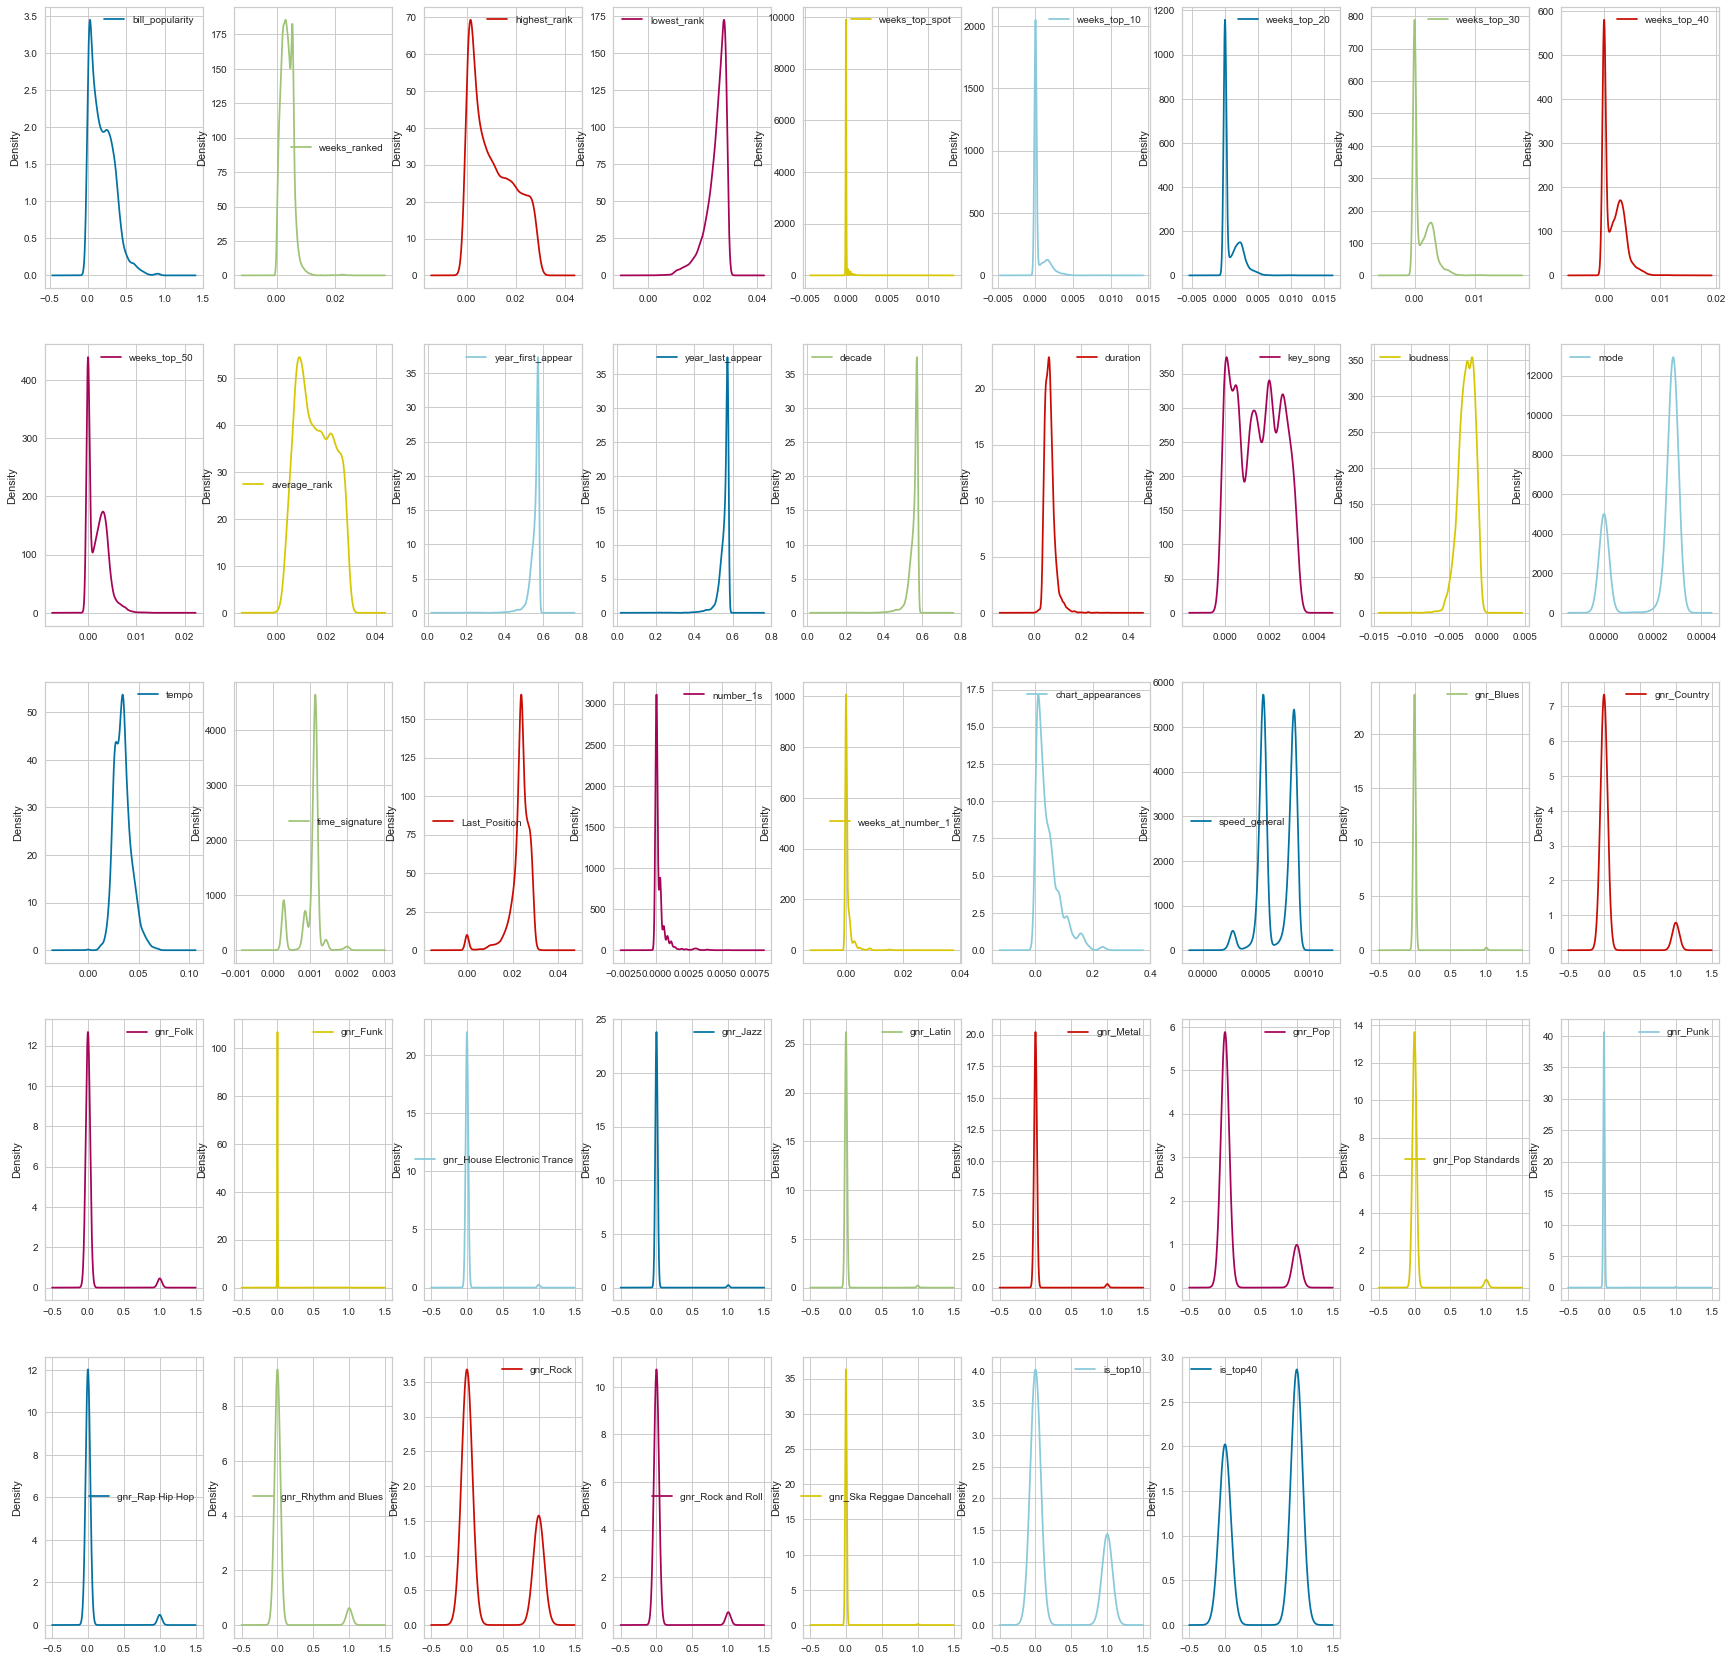

In [28]:
df.plot(kind='kde', subplots=True, layout=(5,9), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Box Plots 

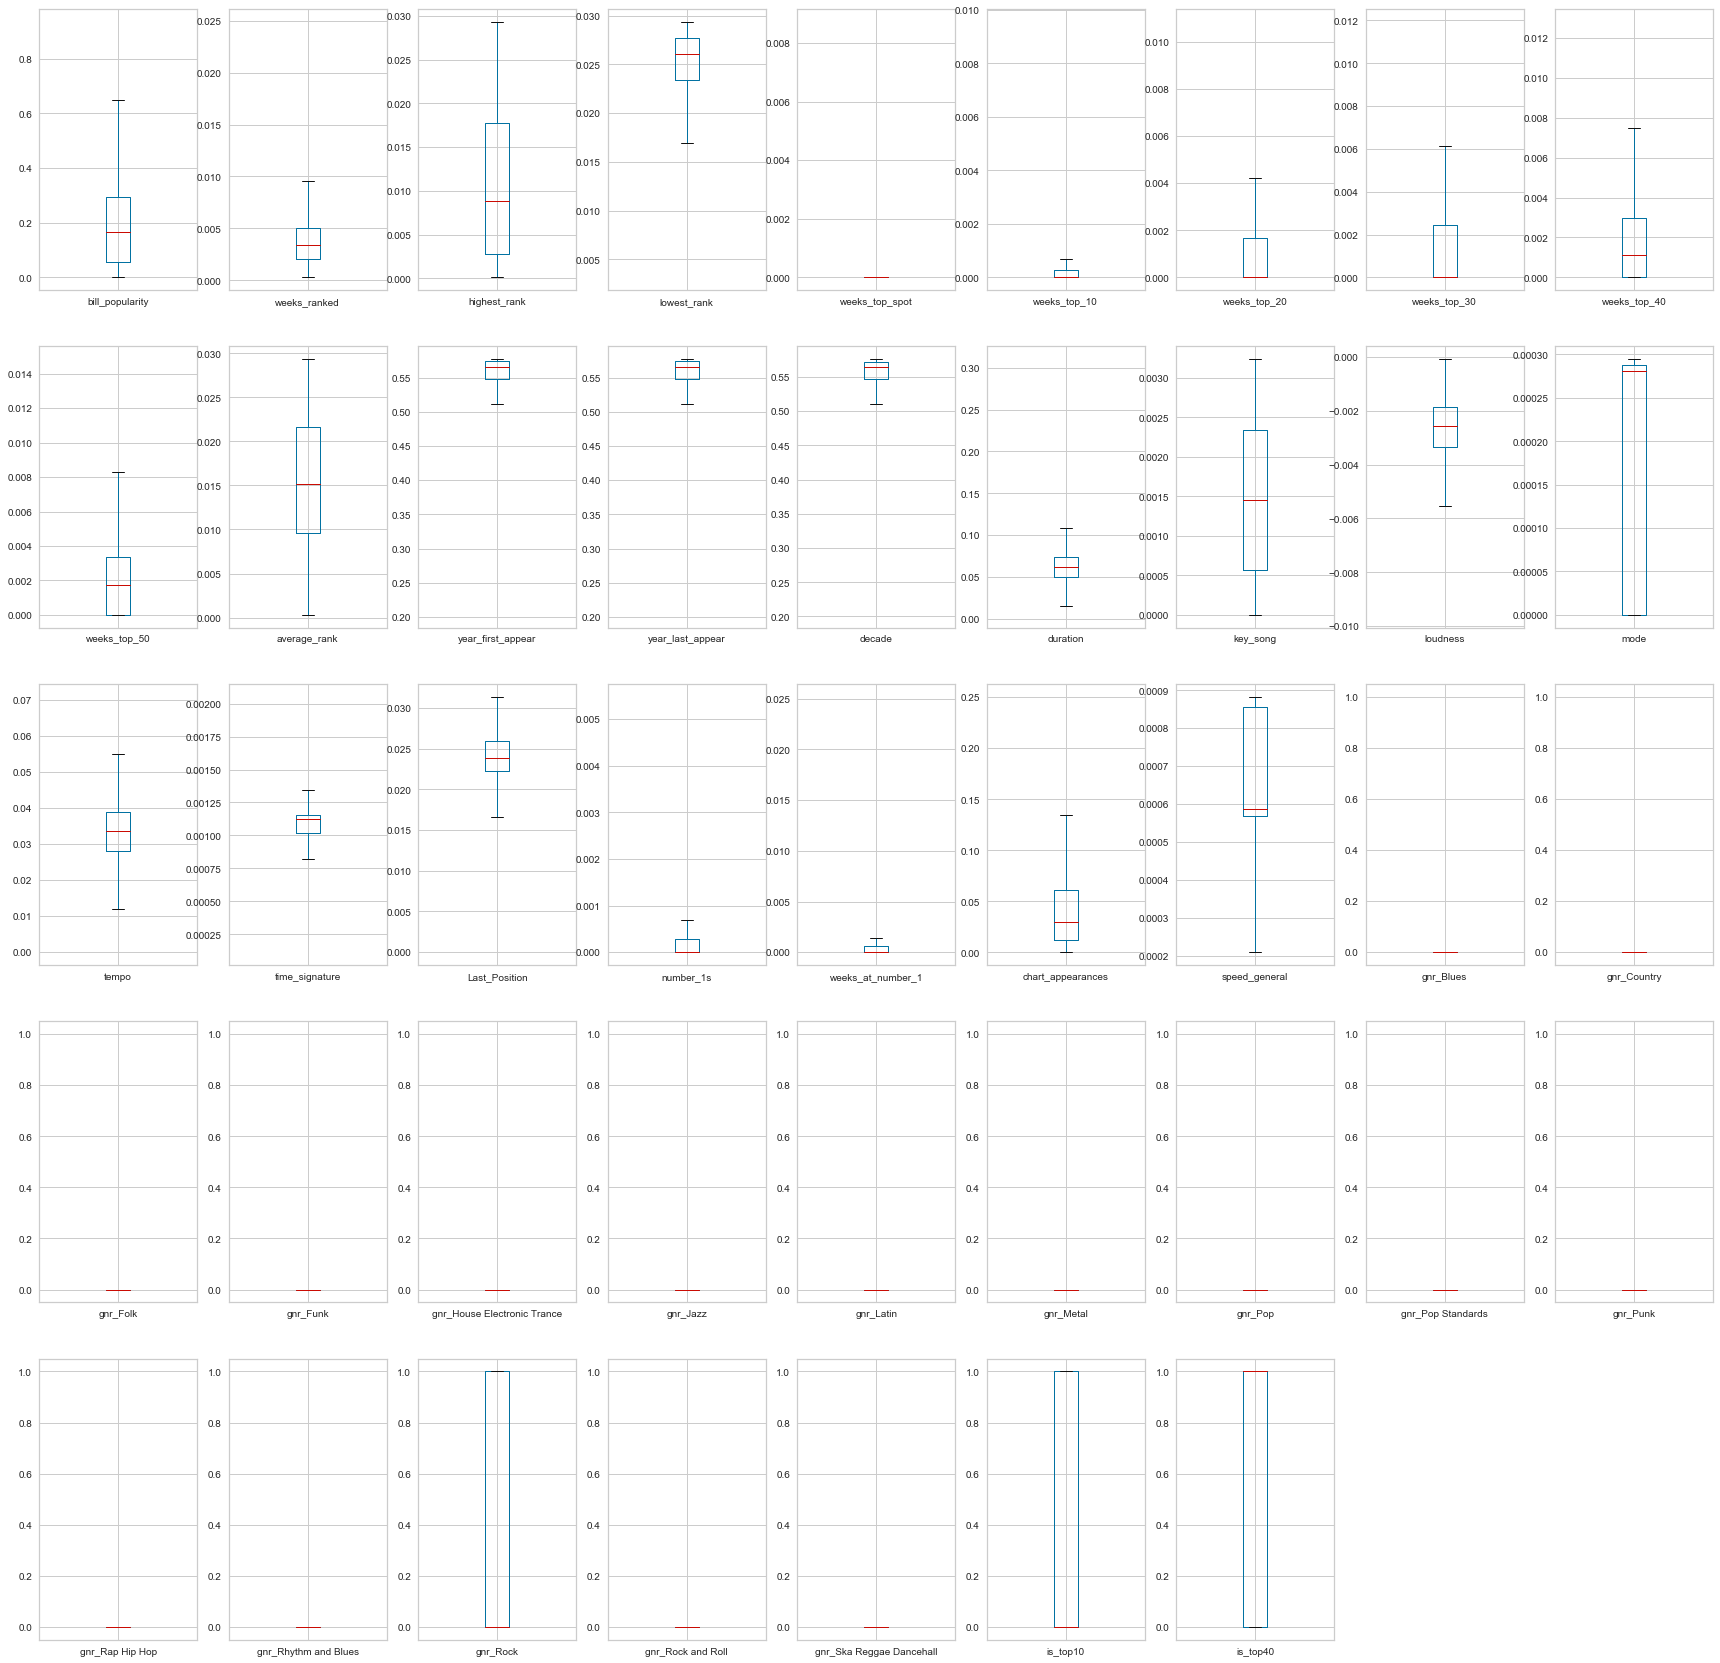

In [8]:
df.plot(kind='box', subplots=True, layout=(5,9), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Parallel Coordinates

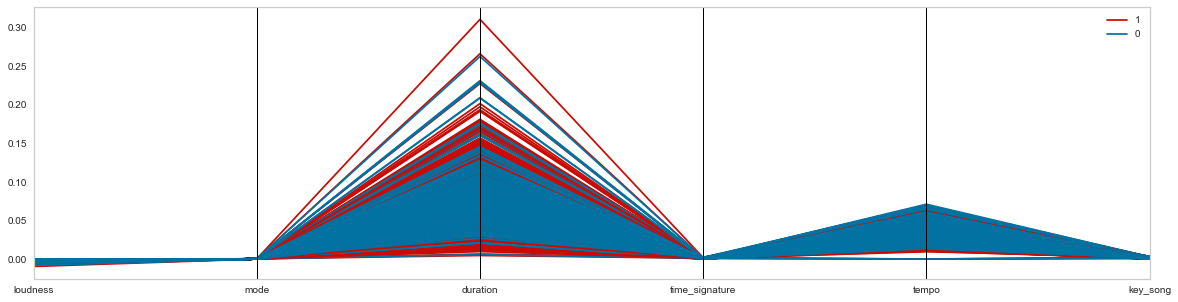

In [34]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(20,5))
dataset = df[['loudness','mode','duration','time_signature','tempo','key_song','is_top40']]
parallel_coordinates(dataset, 'is_top40',color=['r','b'])
plt.show()

### Rad Viz

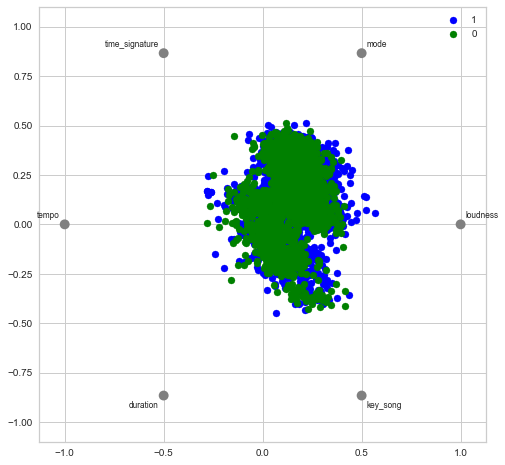

In [17]:
from pandas.plotting import radviz
plt.figure(figsize=(8,8))
dataset = df[['loudness','mode','time_signature','tempo','duration','key_song','is_top40']]
radviz(dataset, 'is_top40',color=['blue','green'])
plt.show()

## Initial Model Comparison

### Split-Out validation dataset

In [18]:
array = df.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

### Test options and evaluation metric

In [19]:
seed = 7
scoring = 'accuracy'

### Selected Algorithms

In [42]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier(n_estimators=10)))

### Initial Evaluation Each Model in Turn

In [21]:
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=12, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.924938 (0.011351)
LDA: 0.991105 (0.004126)
KNN: 0.933833 (0.010352)
CART: 1.000000 (0.000000)
NB: 0.997503 (0.002336)
SVM: 0.905431 (0.008109)
RFC: 1.000000 (0.000000)


### Comparison between Algorithms

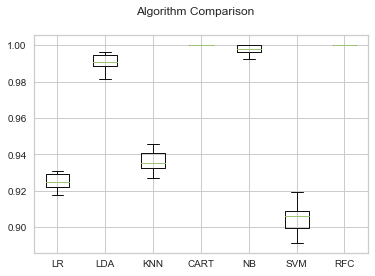

In [22]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Visualize the classification report

In [23]:
def plot_classification_report(cr, name,title='Classification report', cmap=plt.cm.Greens):

    lines = cr.split('\n')
    classes = []
    plotMat = []

    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    fig, ax = plt.subplots(1)
    fig = plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    for c in range(len(plotMat)+1):
        for r in range(len(classes)):
            try:
                txt = plotMat[r][c]
                ax.text(c,r,plotMat[r][c],va='center',ha='center')
            except IndexError:
                pass
            
    plt.title(title+' '+name)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

### Applying the Visualization to the Models

LR
0.9207735495945103
[[600  33]
 [ 94 876]]


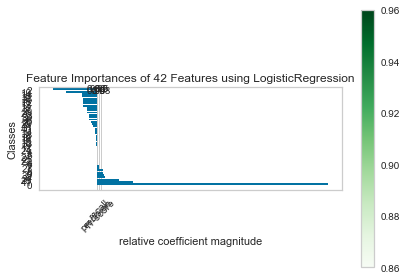

LDA
0.9875233936369308
[[633   0]
 [ 20 950]]


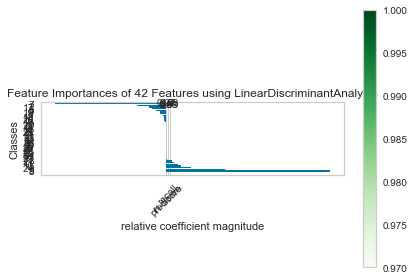

CART
1.0
[[633   0]
 [  0 970]]


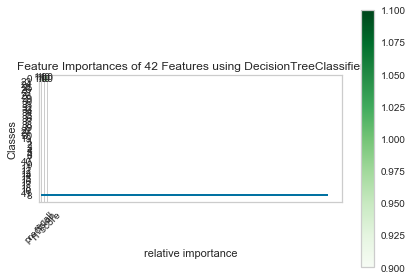

RFC
1.0
[[633   0]
 [  0 970]]


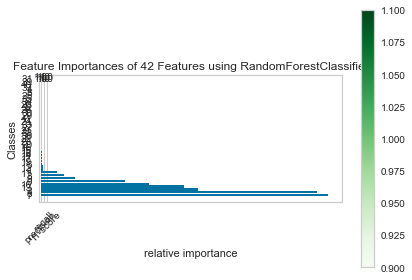

In [43]:
def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    report = cr(Y_validation, predictions)
    plot_classification_report(report,name)
    oz = FeatureImportances(model)
    oz.fit(X_train, Y_train)
    oz.poof()

for name, model in models:
    plotting(name, model)